# JSMA
[Nicolas Papernot et al. in “The Limitations of Deep Learningin Adversarial Settings”](https://arxiv.org/abs/1511.07528).

# 1. 事前準備と確認

## 必要なライブラリのインポート

In [1]:
from imagenet_util import *

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical

## ResNet50 を取得

In [2]:
model = ResNet50(weights='imagenet')

Run the test images through it.

## オリジナル画像のロードと表示

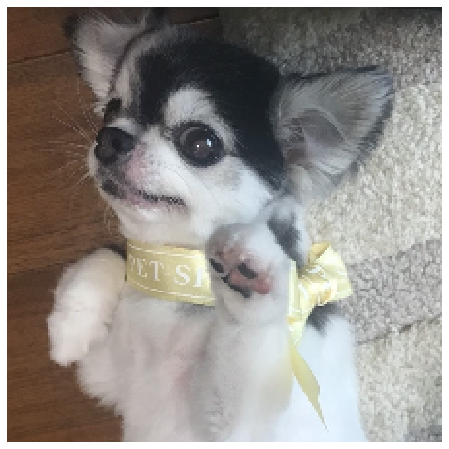

In [3]:
original_image_path = '../../images/chihuahua2.jpg'
original_image = load_img(original_image_path, target_size=(224, 224))
original_image = img_to_array(original_image)
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(original_image/255.0)

## オリジナル画像の正規化

In [4]:
norm_original_image = preprocess_input(original_image.copy())

## オリジナル画像の推論と分類

In [5]:
Y_hat = model.predict(np.expand_dims(norm_original_image, 0)) # 推論
original_class, original_name, original_score = get_top_pred(Y_hat) # 分類

# 分類結果とスコアを表示
print('Prediction: {0} - score {1:.2f}%'.format(original_name, original_score * 100))

Prediction: Chihuahua - score 67.11%


# 2. JSMA クラス開発

## JSMA クラス

In [6]:
class JSMA:
    """JSMA
    Attributes:
        classifier (Model) : モデル
        theta (float): ノイズの大きさを表すハイパーパラメータ
        target_score (float): 目標スコア。ターゲットクラスのスコアがこの値を超えるまでノイズを加える
        mask (ndarray): 更新済みサブピクセルを管理する変数。更新前は1、更新済みは0で管理される `(224, 224, 3)`
    """

    def __init__(self, classifier, theta, target_score):

        # 引数をインスタンス変数にセット
        self.classifier = classifier
        self.theta = theta
        self.target_score = target_score

    def generate(self, norm_input_image, target_class):
        """
        敵対的サンプルを生成する
        Args:
            norm_input_images (ndarray): 正規化された画像 `(224, 224, 3)`
            target_class (int): ターゲットクラス
        Returns:
            norm_adv_image (ndarray): 正規化された敵対的サンプル　`(224, 224, 3)`
        """
        
        # カウンタ
        iter_count = 0
        
        # 初回ステップ用のダミーのクラスとスコアをセット
        adv_class = np.inf
        adv_score = -np.inf

        # マスクを初期化
        self.mask = np.ones(norm_input_image.shape)
        
        # 敵対的サンプルを格納する変数。 norm_input_image を初期値とする
        norm_adv_image = norm_input_image.copy()
        
        #  ターゲットクラスのスコアが目標クラスを超えるまでサブピクセルを更新する
        while not (adv_class == target_class and adv_score > self.target_score):

            # カウンタを更新
            iter_count += 1

            # サブピクセルを更新
            norm_adv_image = self.update(norm_adv_image, target_class)

            # 推論
            Y_hat_adv = self.classifier.predict(np.expand_dims(norm_adv_image, 0))
            
            # 分類
            adv_class, adv_name, adv_score = get_top_pred(Y_hat_adv)

            # 20回ごとにログを表示
            if iter_count % 20 == 0:
                print('Iteration = {0}: Prediction: {1} - score {2:.2f}%'.format(iter_count, adv_name, adv_score * 100))
        
        return norm_adv_image

    def update(self, norm_input_image, target_class):
        """
        Saliency Map を生成し、サブピクセルを更新する
        Args:
            norm_input_image (ndarray): 正規化された画像 `(224, 224, 3)`
            target_class (int): ターゲットクラス
        Returns:
            clipped_norm_input_image (ndarray): norm_input_image を更新した画像 `(224, 224, 3)`
        """

        # 正規化された画像のバッチ化 `(1, 224, 224, 3)`
        X = np.expand_dims(norm_input_image, 0)
        
        # Tensor にキャスト
        X = tf.cast(X, tf.float32) 

        # Saliency Map を生成
        with tf.GradientTape() as tape:
            tape.watch(X)
            y_hat_target = self.classifier(X)[0][target_class] # ターゲットクラスのスコア
        saliency_maps = tape.gradient(y_hat_target, X) # Saliency Map `(1, 224, 224, 3)`

        # バッチデータである saliency_maps から1件目のデータを取得 `(224, 224, 3)`
        saliency_map = saliency_maps[0]
        
        # saliency_map を ndarray に変換
        saliency_map = saliency_map.numpy()
        
        # saliency_map を mask でフィルタ 
        masked_saliency_map = saliency_map * self.mask
        
        # 最大値となる要素のインデックスを取得
        # ここで取得されるインデックスは、masked_saliency_map を1次元配列としたときのインデックスのため、
        # max_index はスカラーとなる
        max_index = np.argmax(masked_saliency_map)
        
        # np.unravel_index　を使って、1次元配列上でのインデックスを3次元配列上でのインデックスに変換する
        # 変換後の max_index はタプルである点に注意
        max_index = np.unravel_index(max_index, masked_saliency_map.shape)

        # max_index　が指すサブピクセルを更新
        norm_input_image[max_index] += self.theta
        
        # max_index が指すサブピクセルが以降に更新されないよう、mask を更新
        self.mask[max_index] = 0

        # クリッピング
        clipped_norm_input_image = clip_imagenet(norm_input_image)

        return clipped_norm_input_image

# 3. 敵対的サンプルの生成と攻撃

## 敵対的サンプル生成の準備


In [7]:
# ノイズの大きさを設定
theta = 0.4 * 255

# 目標スコアを設定
target_score = 0.1

# ターゲットクラスを設定
target_class = 356 # weasel

# JSMA インスタンスを生成
attack = JSMA(model, theta, target_score)

## 敵対的サンプルの生成と攻撃

In [9]:
# 敵対的サンプルの生成
norm_adv_image = attack.generate(norm_original_image, target_class)

# 敵対的サンプルの推論
Y_hat_adv = model.predict(np.expand_dims(norm_adv_image, 0))

# 敵対的サンプルの分類
_, adv_name, adv_score = get_top_pred(Y_hat_adv)

# 推論結果と分類結果を表示
print('\nPrediction: {0} - score {1:.2f}%'.format(adv_name, adv_score * 100))

Iteration = 20: Prediction: Chihuahua - score 51.12%
Iteration = 40: Prediction: Chihuahua - score 42.82%
Iteration = 60: Prediction: Chihuahua - score 45.80%
Iteration = 80: Prediction: Chihuahua - score 46.60%
Iteration = 100: Prediction: Chihuahua - score 41.88%
Iteration = 120: Prediction: Chihuahua - score 43.61%
Iteration = 140: Prediction: Chihuahua - score 40.52%
Iteration = 160: Prediction: Chihuahua - score 34.10%
Iteration = 180: Prediction: Chihuahua - score 31.73%

Prediction: weasel - score 23.78%


## 敵対的サンプルの非正規化

In [ ]:
adv_image = postprocess_imagenet(norm_adv_image)

## L0 の計算

In [ ]:
diff = adv_image - original_image # 加えられたノイズ
L0 = np.linalg.norm(diff.reshape(-1), ord=0) # L0 を計算
print('L0:', L0)

## オリジナル画像、差分、敵対的サンプルの表示

In [ ]:
plt.figure(figsize=(15, 15))

# オリジナル画像を表示
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Original\n {0} - {1:.2f}%'.format(original_name, original_score * 100))
plt.imshow(original_image/255.0)

# 差分を表示
plt.subplot(1, 3, 2)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
diff[diff == 0] = 255
plt.title('Diff\nL0 - {0}'.format(int(L0)))
plt.imshow(diff/255.0)

# 敵対的サンプルを表示
plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('Adversarial\n {0} - {1:.2f}%'.format(adv_name, adv_score * 100))
plt.imshow(adv_image/255.0)

# 4. 敵対的サンプルの保存（誤って読者が実行しないようにコメントアウトしています）

In [ ]:
# np.save('../../data/chihuahua_jsma', adv_image)